# Прогнозирование оттока клиентов

**Цель работы** - смоделировать вероятность оттока клиентов телекоммуникационной компании. 

Эта задача очень важна, алгоритмы для ее решения используются телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы. 

У нас есть два файла - train.csv (содержит колонки признаков и целевую переменную) и test.csv (содержит только колонки признаков). 

В качестве ответа мы получим предсказания вероятностей ухода клиентов для. 

Метрикой для оценки качества модели будет ROC-AUC.

# Первая часть. Исследование

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import optuna

In [114]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier, Pool

## Загрузка данных 

In [36]:
!python -m gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
!python -m gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
!python -m gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y


Downloading...
From: https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
To: c:\Users\Анюта\Desktop\Stepik\Deap learning\Композиции алгоритмов и выбор модели\ДЗ\train.csv

  0%|          | 0.00/664k [00:00<?, ?B/s]
 79%|███████▉  | 524k/664k [00:00<00:00, 1.51MB/s]
100%|██████████| 664k/664k [00:00<00:00, 1.45MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
To: c:\Users\Анюта\Desktop\Stepik\Deap learning\Композиции алгоритмов и выбор модели\ДЗ\test.csv

  0%|          | 0.00/218k [00:00<?, ?B/s]
100%|██████████| 218k/218k [00:00<00:00, 2.31MB/s]
Downloading...
From: https://drive.google.com/uc?id=199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y
To: c:\Users\Анюта\Desktop\Stepik\Deap learning\Композиции алгоритмов и выбор модели\ДЗ\submission.csv

  0%|          | 0.00/14.7k [00:00<?, ?B/s]
100%|██████████| 14.7k/14.7k [00:00<00:00, 14.7MB/s]


In [37]:
# Загрузим данные
df_train = pd.read_csv('train.csv')
df_test= pd.read_csv('test.csv')

In [38]:
# Резделим колонки на признаки

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [39]:
# Познакомимся с данными
print('\n----- Тренировочные данные -----\n')
print('----- Информация -----')
df_train.info()  
print()  
print('----- Случайная подборка строк-----')
print()
display(df_train.sample(5))

print('----- Тестовые данные -----\n')
print('----- Информация -----')
df_test.info() 
print()  
print('----- Случайная подборка строк-----')
print()
display(df_test.sample(5))


----- Тренировочные данные -----

----- Информация -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTe

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
646,41,83.75,3273.55,Male,1,Yes,No,Yes,Yes,Fiber optic,Yes,No,Yes,No,No,No,Month-to-month,Yes,Bank transfer (automatic),1
3226,24,53.60,1315.35,Male,0,Yes,No,Yes,No,DSL,Yes,No,No,Yes,No,No,Month-to-month,No,Mailed check,0
2888,68,19.35,1292.65,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),0
3469,31,90.55,2929.75,Male,0,Yes,No,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),0
5004,15,69.00,994.8,Female,0,No,Yes,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),1


----- Тестовые данные -----

----- Информация -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupp

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
1061,51,76.40,3966.3,Male,0,Yes,Yes,Yes,No,DSL,Yes,No,No,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic)
1744,13,20.00,268.45,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
955,60,89.55,5231.2,Male,0,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,No,Two year,Yes,Electronic check
1604,31,49.85,1520.1,Female,0,No,No,No,No phone service,DSL,Yes,Yes,No,Yes,No,Yes,Two year,Yes,Bank transfer (automatic)
157,52,49.75,2535.55,Female,0,No,No,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic)


Видим, что признак `TotalSpent` имеет тип object. Поменяем тип.

При смене типа столнулись с наличием пробелов, таких строк 9, принято решение заполнить их **медианой**.

In [40]:
df_train['TotalSpent'] = df_train['TotalSpent'].replace(" ", np.nan).astype(float)
df_train['TotalSpent'] = df_train['TotalSpent'].fillna(df_train['TotalSpent'].median())

df_test['TotalSpent'] = df_test['TotalSpent'].replace(" ", np.nan).astype(float)
df_test['TotalSpent'] = df_test['TotalSpent'].fillna(df_test['TotalSpent'].median())

display(df_train[df_train['TotalSpent'] == ' '])
display(df_test[df_test['TotalSpent'] == ' '])

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod


Проверим остальные данные.

In [41]:
df_train = df_train.replace({' ': np.nan})
display(df_train.isna().sum())

df_test = df_test.replace({' ': np.nan})
display(df_test.isna().sum())

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64

Мы видим, что пропусков ни в тестовых, ни в тренировочных данных нет. 

In [42]:
# Проверим дубли
print(df_train.duplicated().any())
print(df_test.duplicated().any())

True
True


Дублей в данных тоже не наблюдаем

In [43]:
# Познакомимся в некоторыми срезами числовых признков.
print('----- Обучающая выборка -----')
display(df_train[['ClientPeriod', 'MonthlySpending', 'TotalSpent']].describe().T)
print('----- Тестовая выборка -----')
display(df_test[['ClientPeriod', 'MonthlySpending', 'TotalSpent']].describe().T)

----- Обучающая выборка -----


,count,mean,std,min,25%,50%,75%,max
ClientPeriod,5282.0,32.397009,24.550326,0.00,9.0000,29.00,55.0000,72.00
MonthlySpending,5282.0,64.924754,30.176464,18.25,35.4625,70.40,90.0500,118.75
TotalSpent,5282.0,2289.889086,2267.371263,18.80,401.5875,1410.25,3795.2125,8684.80


----- Тестовая выборка -----


,count,mean,std,min,25%,50%,75%,max
ClientPeriod,1761.0,32.293583,24.593736,0.00,9.00,29.00,56.00,72.00
MonthlySpending,1761.0,64.272601,29.832517,18.55,35.65,70.05,89.40,117.35
TotalSpent,1761.0,2258.023964,2259.424696,18.85,412.10,1356.70,3759.05,8496.70


#### Итог:

1. У признака 'TotalSpent' очень большой разброс значений, есть выбросы сверху. Решение о замене пропусков медианой, а не средним, было верным.

2. Данные в обучающей и тренировочной выбоках примерно однородны.

3. Следует ближе изучить категориальные признаками, поскольку они составляют большую часть датасета.

## Анализ данных 

В этой части будем работать с самими данными:

- Попробуем обработать категориальные признаки
- Оценим данные на предмет аномалий и выбросов
- Посмотрим на сбалансированность данных в разрезе целевой переменной.
- Рассмотрим целевую переменную в разрезе категориальных и числовых признаков.

Для начала познакомимся с категориальными прихнаками и их значениями.

In [44]:
for col in cat_cols:
    print(f'--- {col} ---')
    #print(df_train[col].value_counts())
    print(f'Уникальные значения: {df_train[col].unique()}')
    print('')

--- Sex ---
Уникальные значения: ['Male' 'Female']

--- IsSeniorCitizen ---
Уникальные значения: [0 1]

--- HasPartner ---
Уникальные значения: ['Yes' 'No']

--- HasChild ---
Уникальные значения: ['Yes' 'No']

--- HasPhoneService ---
Уникальные значения: ['Yes' 'No']

--- HasMultiplePhoneNumbers ---
Уникальные значения: ['No' 'Yes' 'No phone service']

--- HasInternetService ---
Уникальные значения: ['No' 'Fiber optic' 'DSL']

--- HasOnlineSecurityService ---
Уникальные значения: ['No internet service' 'No' 'Yes']

--- HasOnlineBackup ---
Уникальные значения: ['No internet service' 'No' 'Yes']

--- HasDeviceProtection ---
Уникальные значения: ['No internet service' 'No' 'Yes']

--- HasTechSupportAccess ---
Уникальные значения: ['No internet service' 'Yes' 'No']

--- HasOnlineTV ---
Уникальные значения: ['No internet service' 'No' 'Yes']

--- HasMovieSubscription ---
Уникальные значения: ['No internet service' 'No' 'Yes']

--- HasContractPhone ---
Уникальные значения: ['One year' 'Two y

Для признаков, где есть значение `No internet service`, будет вполне уместным объединить их со значением `No` 

In [45]:
repl_dct = {'No phone service': 'No', 'No internet service': 'No'}
df_train = df_train.replace(repl_dct)
df_test = df_test.replace(repl_dct)

In [12]:
#for col in cat_cols:
#    print(f'--- {col} ---')
#    print(df_train[col].value_counts()) 
#    print()  

В результате, больщая часть наших признаков стала бинарной, что позволит нам применить к ним OneHotEncoding, не увеличивая число стобцов.

    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'IsBillingPaperless',

А остальные признаки будем кодировать, как есть.

    'HasInternetService', 
    'HasContractPhone', 
    'PaymentMethod' 

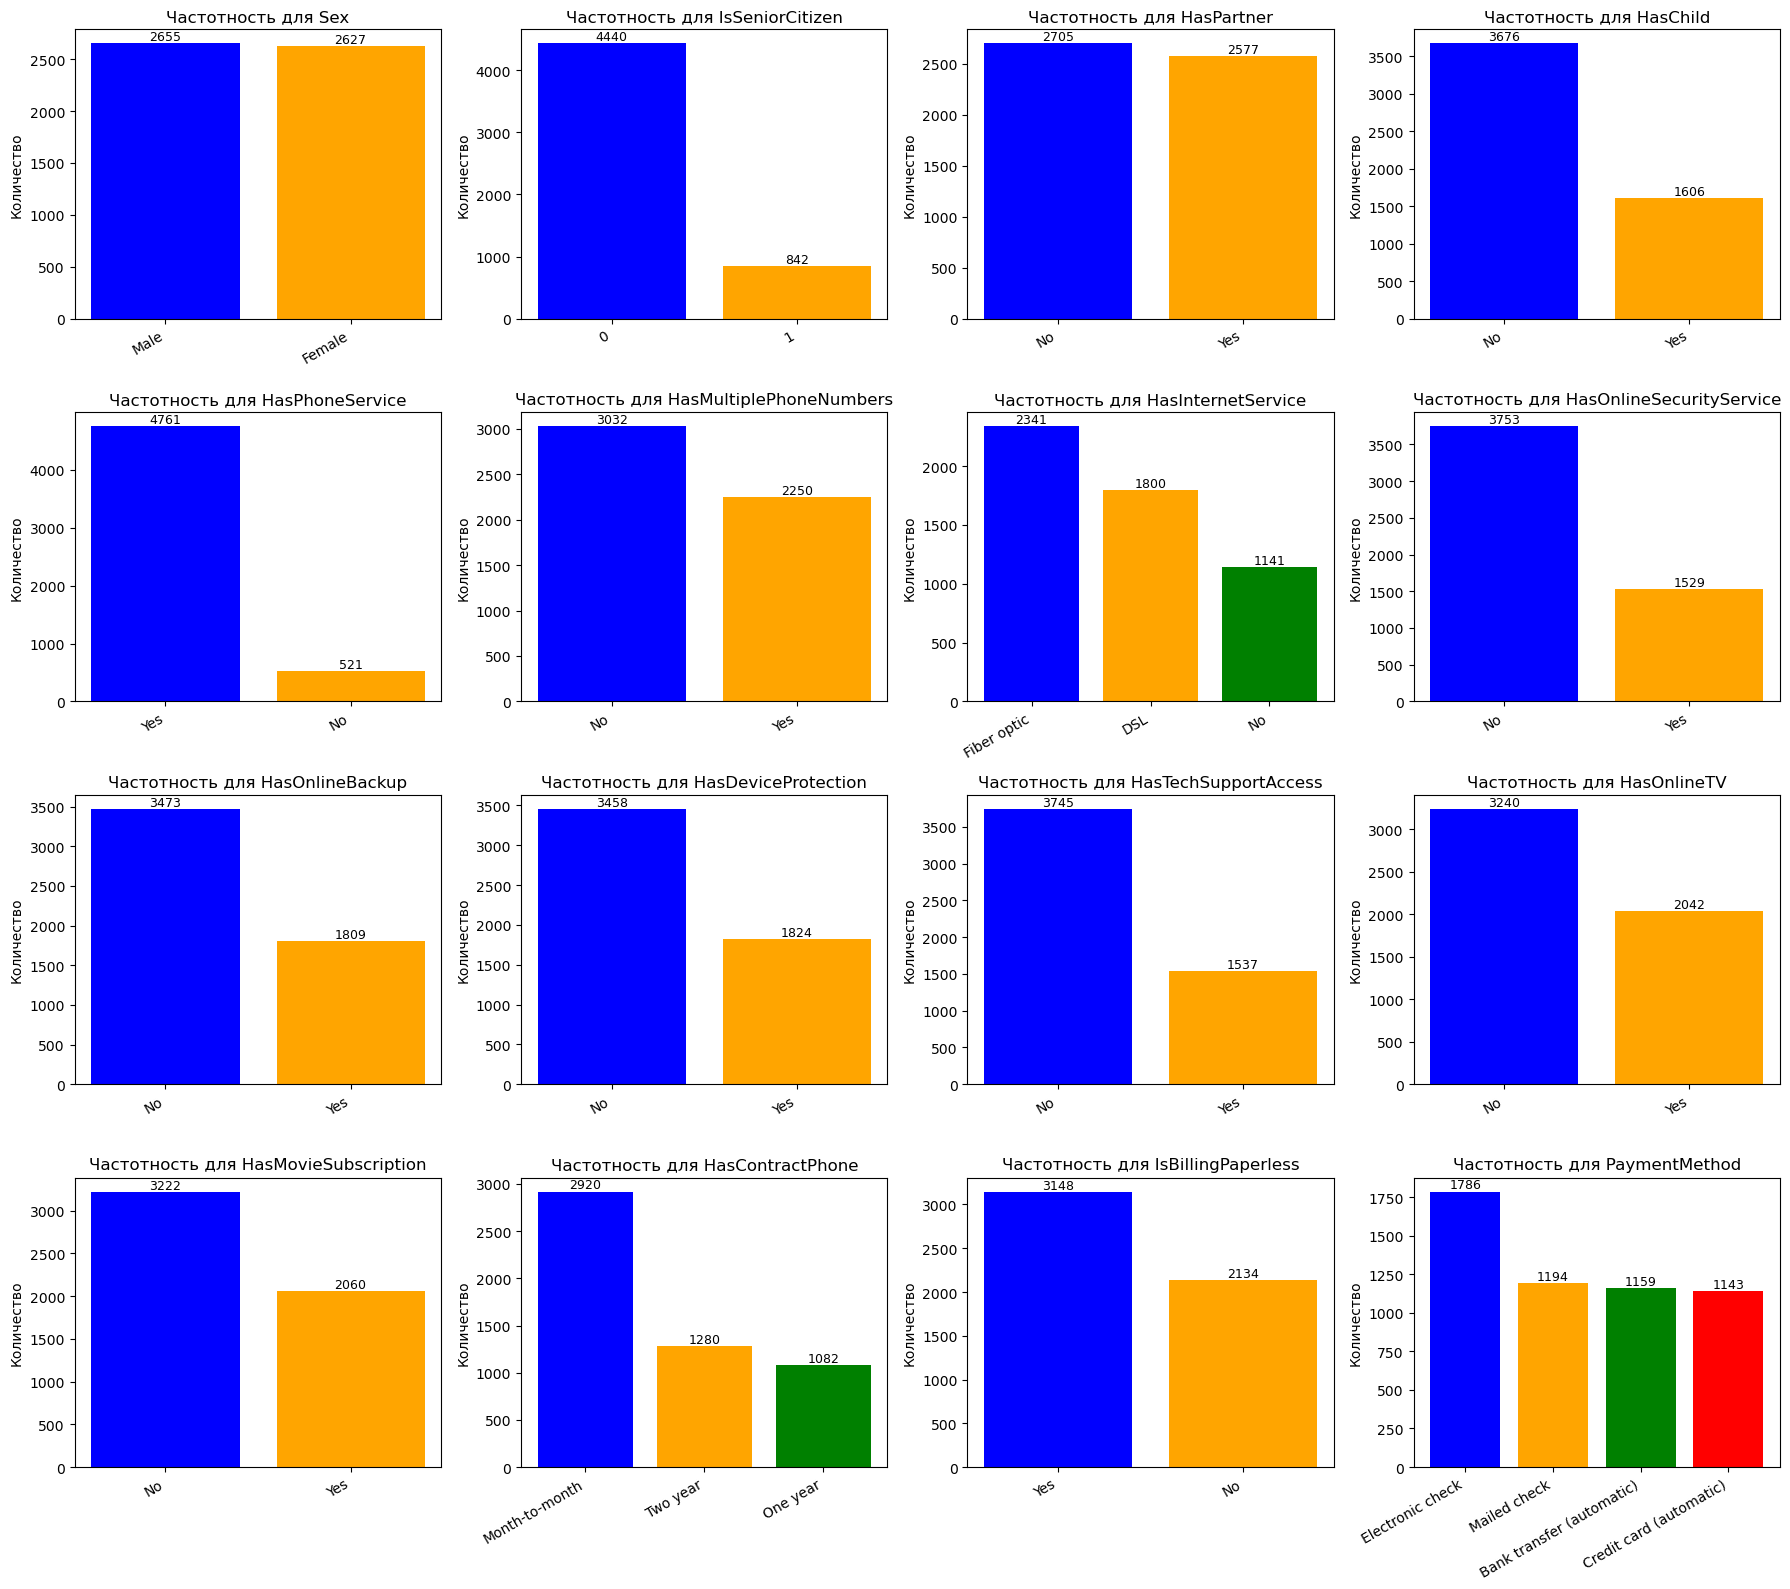

In [46]:
# Построим , посмотрим разбиение
fig, axes = plt.subplots(4, 4, figsize=(18, 16))

for ax, col in zip(axes.flatten(), cat_cols):
    counts = df_train[col].value_counts()
    bars = ax.bar(counts.index, counts.values, color=['blue', 'orange', 'green', 'red'])
    ax.set_title(f'Частотность для {col}')
    ax.set_ylabel('Количество')
    
    ax.set_xticks(range(len(counts.index)))
    ax.set_xticklabels(counts.index, rotation=30, ha='right')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

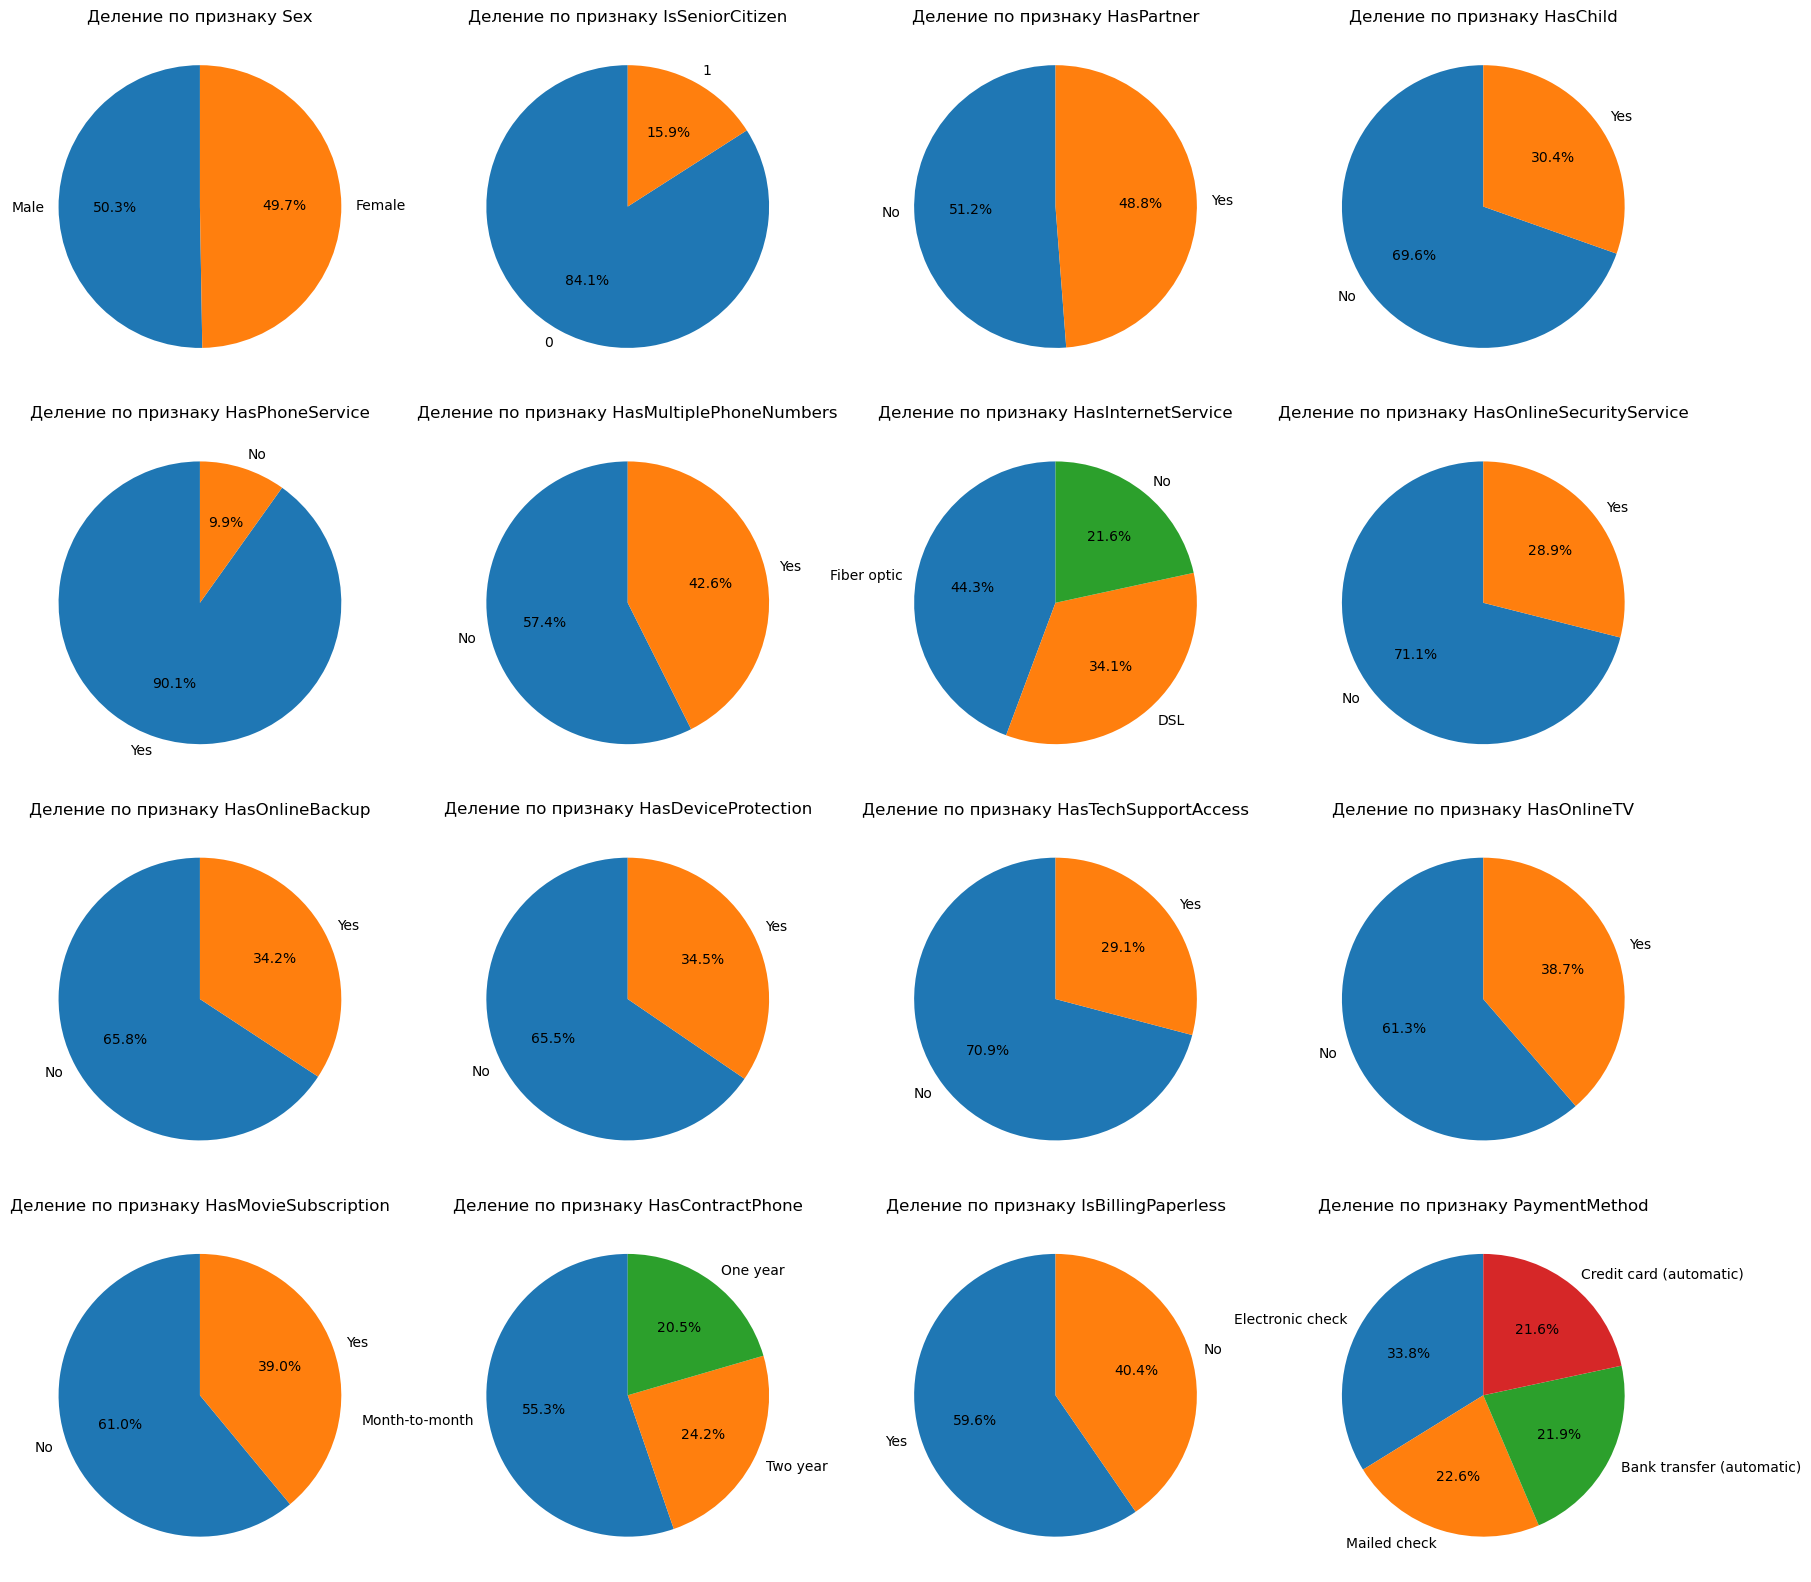

In [47]:
fig, axes = plt.subplots(4, 4, figsize=(18, 16))

for ax, col in zip(axes.flatten(), cat_cols):
    counts = df_train[col].value_counts()
    ax.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Деление по признаку {col}')

plt.tight_layout()
plt.show()


#### Итог

По каким-то признакам мы видим ярко выраженное смещение с торону ничия/ отсутсвия того или иного признака, по каким-то такого яркого проявления нет. 

Сдеюует рассмотреть категориальные признаки в разрезе целевой переменной.

#### Перейдем к числовым признакам

Построим гистограмму и ящик с усами для ознакомления с данными, посмотрим аномалии.

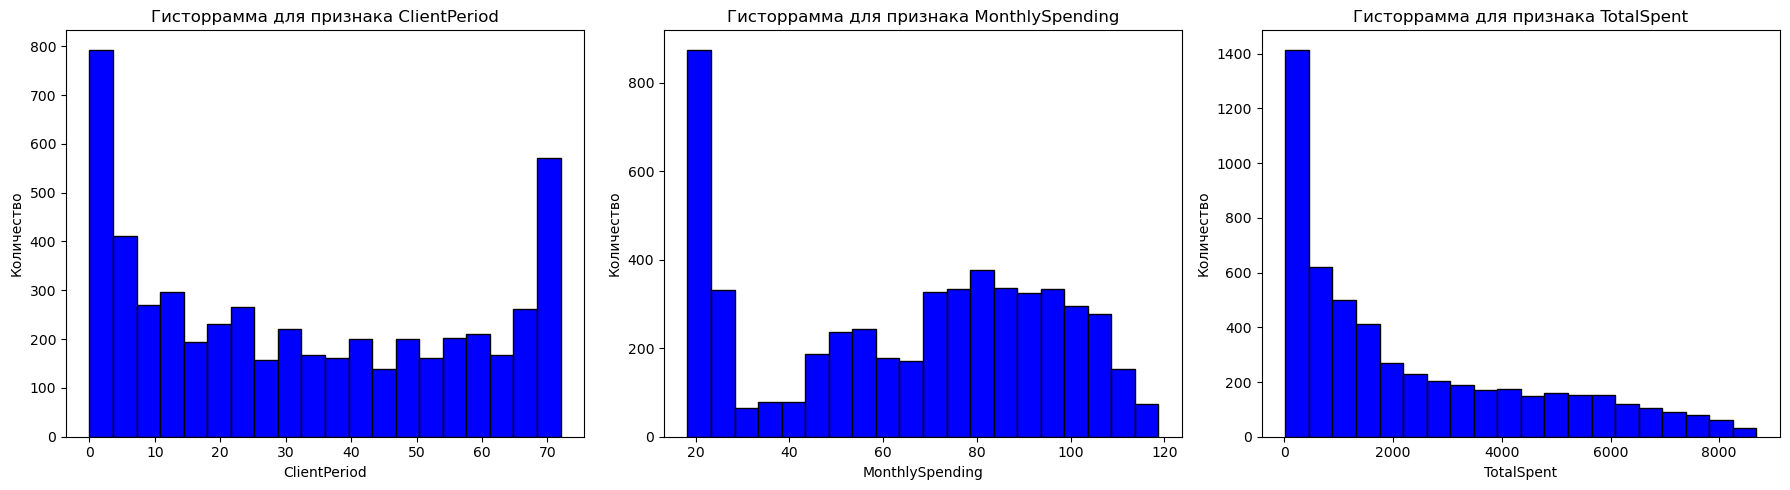

In [48]:
# Работа с числовыми признаками.
fig, axes = plt.subplots(1, len(num_cols), figsize=(18, 5))

for i, col in enumerate(num_cols):
    axes[i].hist(df_train[col], bins=20, color='blue', edgecolor='black')
    axes[i].set_title(f'Гисторрамма для признака {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Количество')

plt.tight_layout()
plt.show()

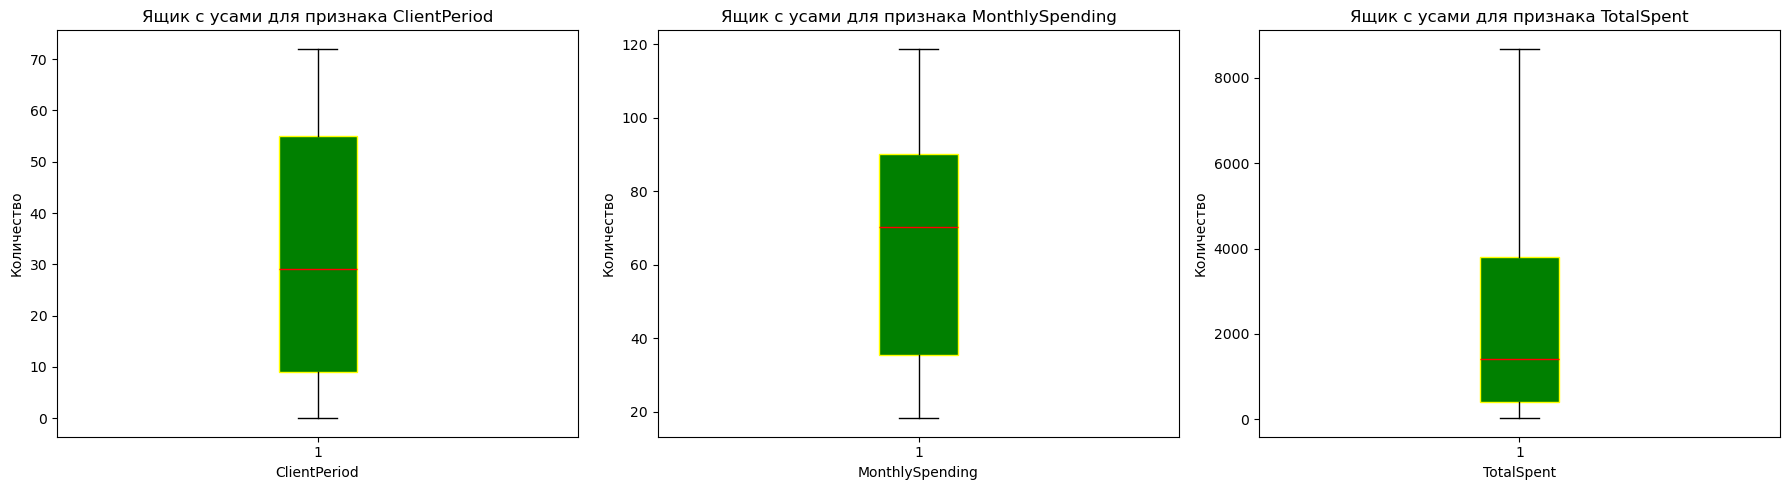

In [49]:
fig, axes = plt.subplots(1, len(num_cols), figsize=(18, 5))

for i, col in enumerate(num_cols):
    axes[i].boxplot(df_train[col], patch_artist=True,
                boxprops=dict(facecolor='green', color='yellow'),
                medianprops=dict(color='red'))
    axes[i].set_title(f'Ящик с усами для признака {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Количество')

plt.tight_layout()
plt.show()

In [51]:
df_train['ClientPeriod'].value_counts().head()

ClientPeriod
1     457
72    284
2     165
3     162
4     136
Name: count, dtype: int64

#### ИТог:

- ClientPeriod 
рассматриваемый диапазон до 72 месяцев, много новых пользователй в диапазоне 1-5 месяцев (часто приходят по акциям) и среди них всегда больше вероятности оттока, много тех, кто с компанией уже 6 лет (их в целом все устраивает) - у компании есть “ядро” постоянных клиентов платежеспособных клиентов. Обычно, чем дольше клиент с компанией, тем меньше вероятность, что он уйдёт - не будем их удалять.

- MonthlySpending
Расходы от ≈18 до 120 реалистичны для телеком-тарифов. Распределение правостороннее (большинство клиентов тратят меньше) и это естественно.

- TotalSpent
Значения от ≈0 до 8700 логичны, ведь это накопленная сумма за месяцы использования. Длинный хвост (много клиентов с малым опытом и мало - с большим) тоже вролне обыно. Высокие значения - то, что принесли компании 'старые' (долгосрочные) клиенты. Ничего удалять не будем.

<u>Оставляем данные без изменений. Ничего удалять не будем.</u>

#### Переходим к целевому признаку

In [52]:
# Распределение целевого признака
churn_counts = df_train['Churn'].value_counts()

churn_percent = churn_counts / len(df_train) * 100

print(f"Осталось: {churn_counts[0]} ({churn_percent[0]:.1f}%)")
print(f"Ушло: {churn_counts[1]} ({churn_percent[1]:.1f}%)")

Осталось: 3898 (73.8%)
Ушло: 1384 (26.2%)


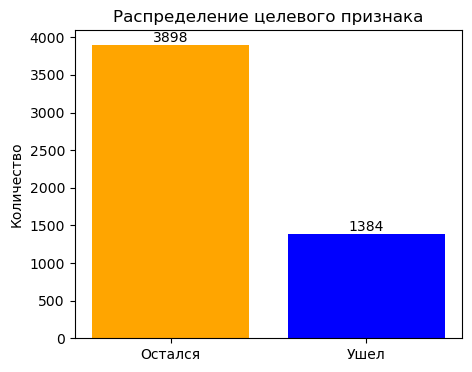

In [53]:
plt.figure(figsize=(5,4))
bars = plt.bar(churn_counts.index, churn_counts.values, color=['orange','blue'])
plt.xticks([0,1], ['Остался', 'Ушел'])
plt.ylabel('Количество')
plt.title('Распределение целевого признака')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(int(height)),
             ha='center', va='bottom', fontsize=10)

plt.show()

#### Итог:

Мы видим, что `классы несбалансированы`, значительная часть клиентов осталась, а ушедших меньше четверти. 

Для обучения моделей важно учитывать этот перекос. 

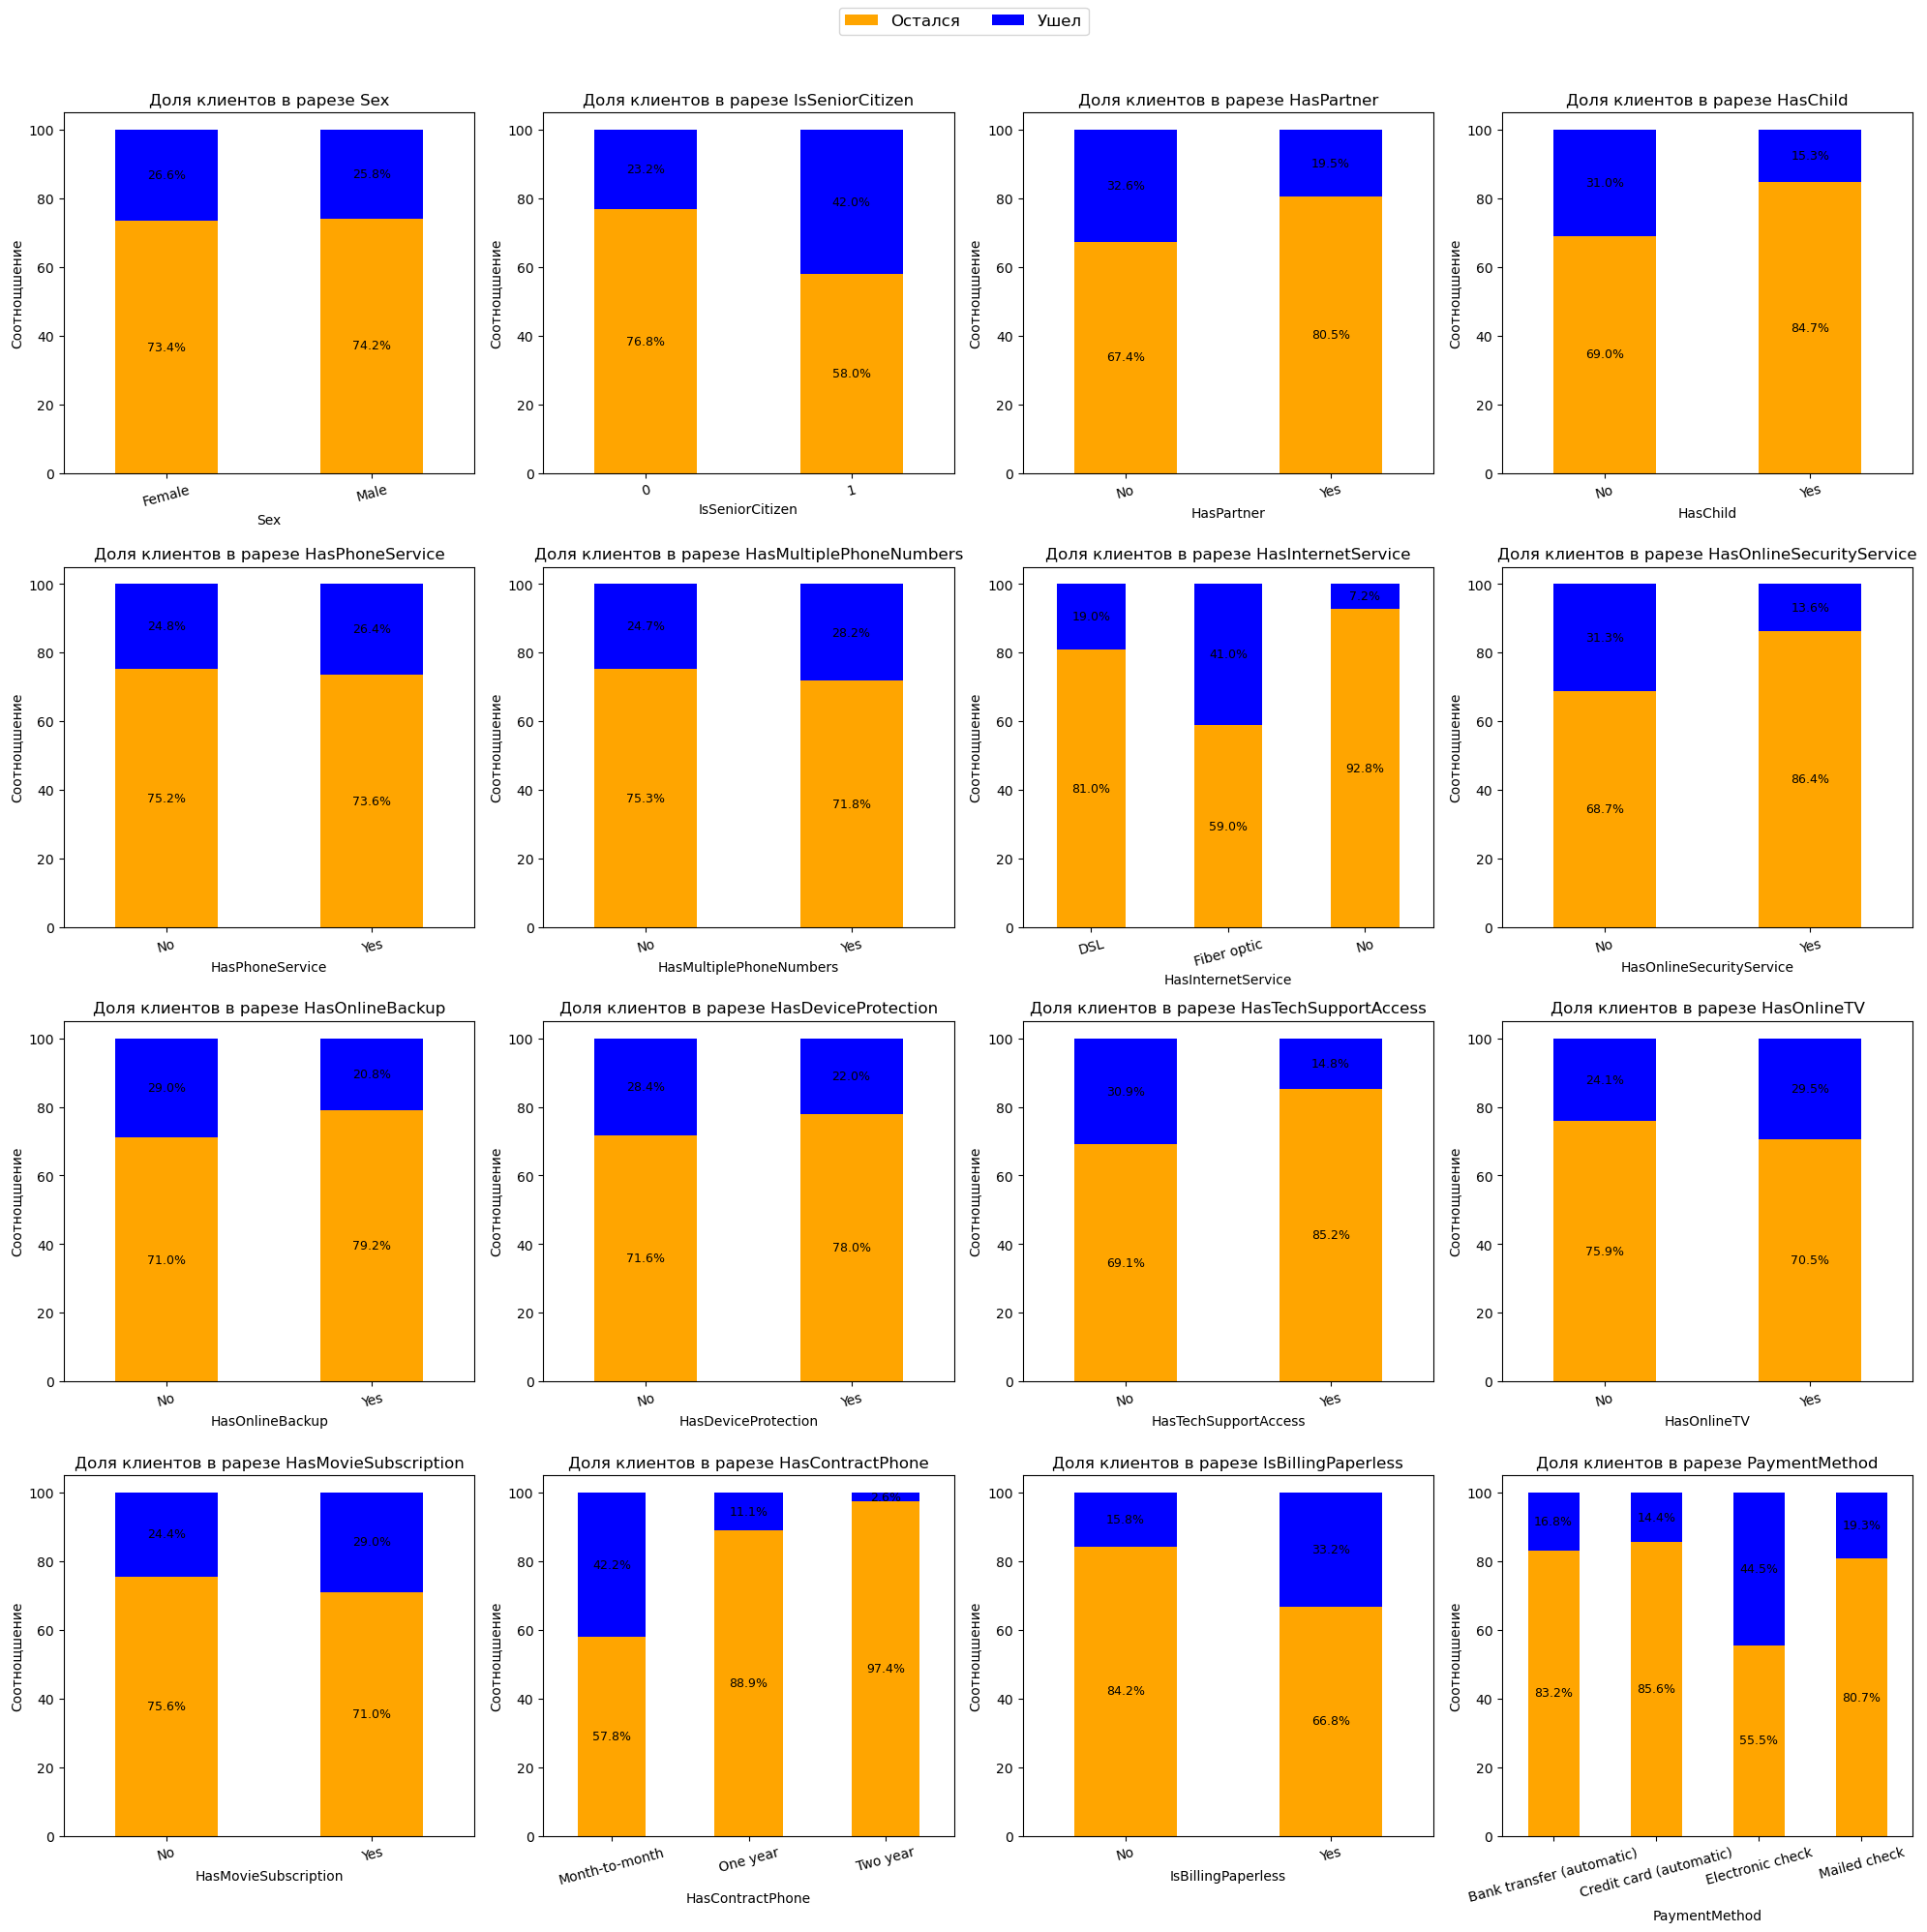

In [54]:
# Посмотрим на категориальные признаки в разрезе целевой переменной

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for ax, col in zip(axes, cat_cols):
    crosstab = pd.crosstab(df_train[col], df_train['Churn'], normalize='index') * 100
    crosstab.plot(kind='bar', stacked=True, ax=ax, color=['orange','blue'], legend=False)

    ax.set_title(f'Доля клиентов в рарезе {col}')
    ax.set_ylabel('Соотнощшение')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)

    for i, container in enumerate(ax.containers):
        ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9, color='black')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, ['Остался','Ушел'], loc='upper center', ncol=2, fontsize=12)

plt.tight_layout(rect=[0,0,1,0.96])  
plt.show()

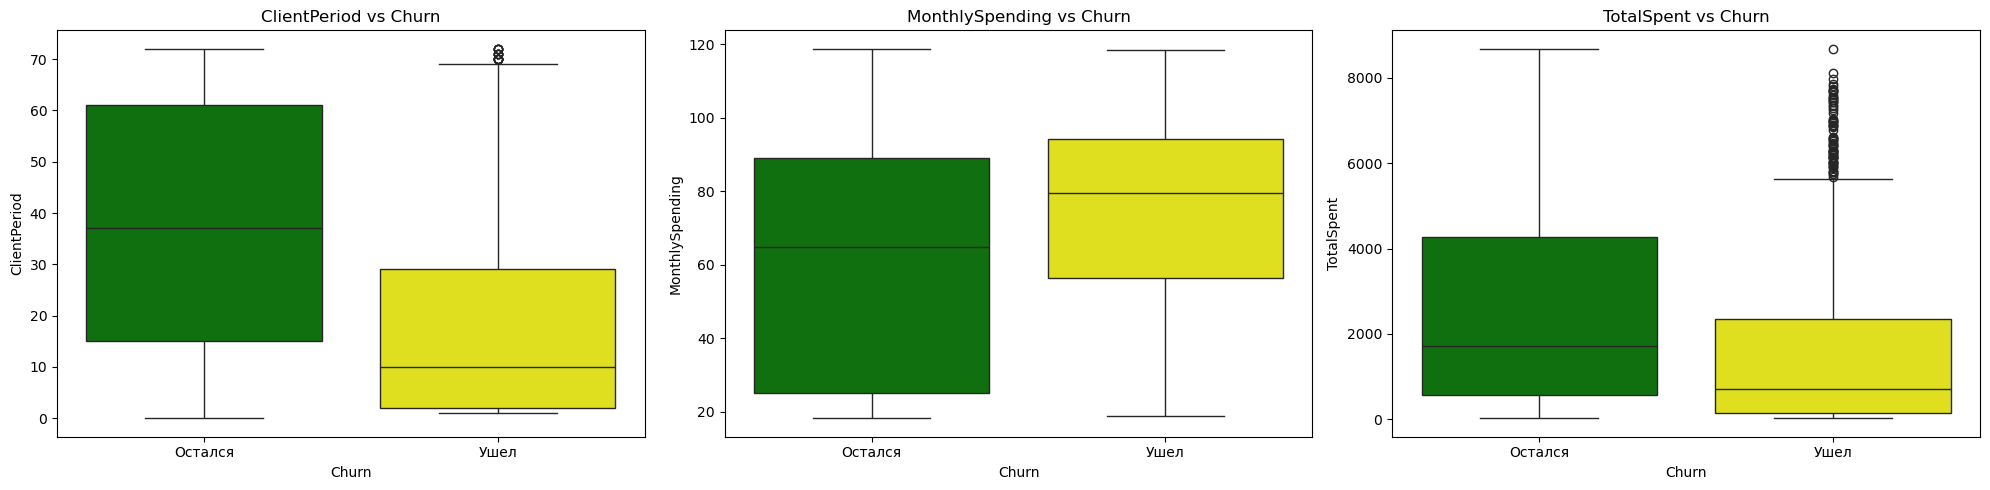

In [55]:
# Посмотрим на числовые признаки в разрезе целевой переменной
fig, axes = plt.subplots(1, len(num_cols), figsize=(20,5))

for ax, col in zip(axes, num_cols):
    sns.boxplot(data=df_train, y=col, x='Churn', hue='Churn', ax=ax, palette=['green','yellow'], dodge=False, legend=False)
    ax.set_title(f'{col} vs Churn')
    ax.set_xlabel('Churn')
    ax.set_ylabel(col)
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Остался','Ушел'])

plt.tight_layout()
plt.show()

#### Итог:

1. Поскольку в целом в датасете больше клиентов, которые остались, это логично отражается и в разрезе каждого признака.

2. Лишь 2 показателя - 'HasInternetService' и 'PaymentMethod' не поддерживают общую тенденцию - там есть показатели, где число клиенто
в ушедших и оставшихмя близко к соотношению 1:1

3. 'Старые' клиенты меньше склонны к оттоку и за долгий скрок обслуживания принесли больше денег компании. Новые клиенты больше подвержены оттоку.

Постром матрицу корреляции и посмотрим на зависимости

<Axes: >

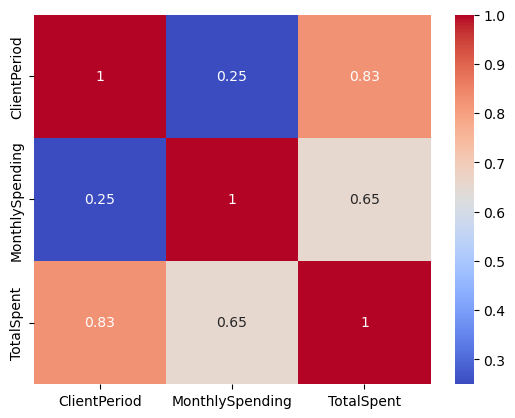

In [56]:
# Посмотрим на корреляцию числовых признаков
corr = df_train[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

Что мы видим:

- `TotalSpent и ClientPeriod`	0.83	очень сильная связь, почти линейная зависимость
- `MonthlySpending и TotalSpent`	0.65	умеренная зависимость, но не полная 

`TotalSpent` это фактически сумма за всё время и логично, что она тесно связана с `ClientPeriod`. Чем дольше клиент остаётся, тем больше он тратит, накопленный результат. `TotalSpent` сильно дублирует `ClientPeriod`.

`MonthlySpending` имеет чуть другую природу - это поведенческий фактор (насколько активен клиент сейчас),

Возможно, `MonthlySpending` даёт дополнительный сигнал (например, кто-то давно с компанией, но тратит мало - потенциальный уход).

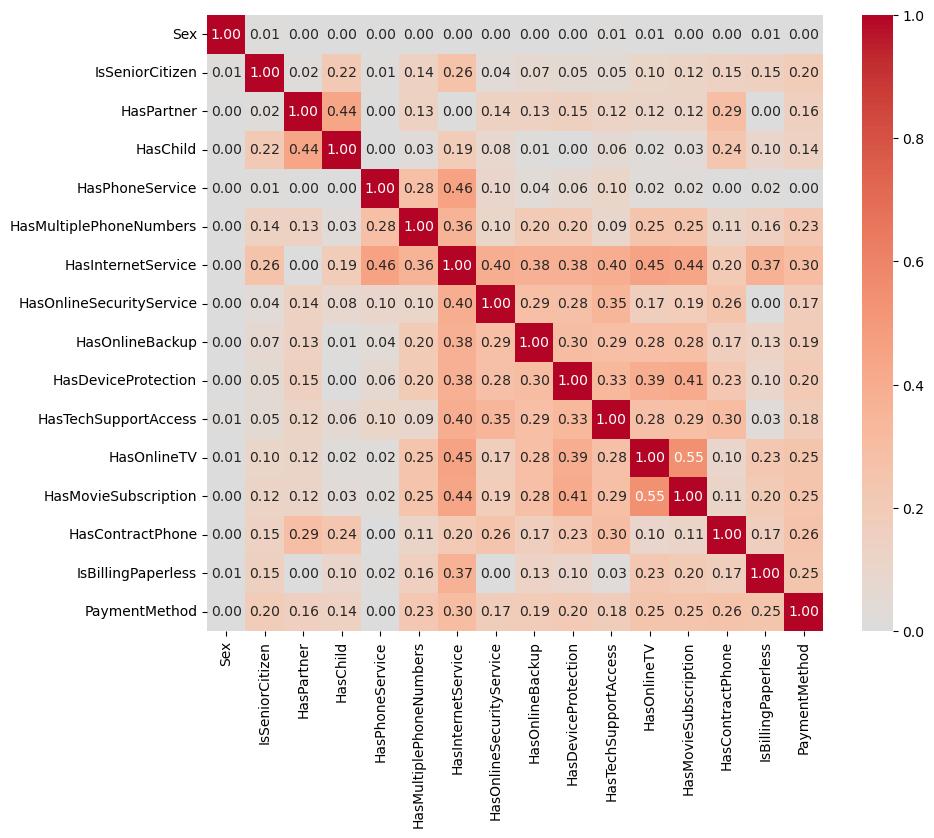

{'corr':                                Sex  IsSeniorCitizen  HasPartner  HasChild  \
 Sex                       1.000000         0.013207    0.000000  0.003479   
 IsSeniorCitizen           0.013207         1.000000    0.016764  0.217007   
 HasPartner                0.000000         0.016764    1.000000  0.441946   
 HasChild                  0.003479         0.217007    0.441946  1.000000   
 HasPhoneService           0.000000         0.008763    0.000000  0.000000   
 HasMultiplePhoneNumbers   0.000000         0.135267    0.133163  0.027194   
 HasInternetService        0.000000         0.258260    0.000000  0.190937   
 HasOnlineSecurityService  0.000000         0.035052    0.142601  0.079230   
 HasOnlineBackup           0.000000         0.068258    0.133329  0.008203   
 HasDeviceProtection       0.000000         0.048119    0.152819  0.000000   
 HasTechSupportAccess      0.007967         0.054669    0.120659  0.055567   
 HasOnlineTV               0.005187         0.104599    

In [58]:
# Посмотрим на корреляцию категориальных признаков
from dython.nominal import associations

associations(
    df_train[cat_cols],
    plot=True,
    cmap='coolwarm',
    figsize=(10,8)
)


In [ ]:
# Оценим значимость признаков

# Преобразование признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ]
)

X_transformed = preprocessor.fit_transform(df_train)
Y = df_train[target_col].astype(float)  
X_transformed = sm.add_constant(X_transformed)

# Линейная регрессия
model = sm.OLS(Y, X_transformed)
results = model.fit()

print(results.summary())

# Логистическая регрессия
logit_model = sm.Logit(Y, X_transformed)
results = logit_model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     89.70
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:28:13   Log-Likelihood:                -2281.1
No. Observations:                5282   AIC:                             4610.
Df Residuals:                    5258   BIC:                             4768.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0921      0.202      0.456      0.6

Для категориальных признаков нашего датасета мы построили матрицу корреляций. Она показала, что некоторые признаки сильно связаны между собой, например:

HasPhoneService и HasMultiplePhoneNumbers имеют почти полную корреляцию,

HasInternetService, HasOnlineSecurityService, HasOnlineBackup, HasDeviceProtection и HasTechSupportAccess также демонстрируют высокие взаимозависимости.

Это указывает на избыточность признаков: такие признаки могут дублировать информацию друг друга. Удаление одного из пары сильно коррелированных признаков может упростить модель, уменьшить риск мультиколлинеарности и ускорить обучение, при этом не теряя значимой информации.

Для признаков с низкой корреляцией удаление не требуется, так как они дают уникальную информацию.


Появилось предположение, что удаление части признаков может улучшить нашу модель.

Сначала проведем сравнение результатов, а уже потом сделаем выводы о целесообразности удаления.

В целом, обработка проведена (смена типов данных, замена пропусков, укрупнение признаком) и принято решшение ничего не удалять, считаем, что данные готовы к использоваунию для обучения.

## Построение моделей

## Линейные модели

В качестве линейно модели построим модель логистической регерессии (Pipeline + GridSearchCV), потому что он безопаснее для работы с разными признаками и легко расширяется для сложных предобработок.

Рассмотрим 4 варинта формирования данных:
1. Без изменений
2. рансформируем категориальные : уберем один дублирцющий признак и объединим признаки с высокой корреляцией
3. Уберем признак `TotalSpent`
4. Скомбинируем варианты 2 и 3

Помним, что данные у нас несбалансированны, потому для оценки моделей по таким данным разумно использовать метрику ROC-AUC.


In [73]:
# Создадим 4 датасета, чтобы оценить метрики
# Разделяем признаки и целевую
X = df_train[feature_cols].copy()
y = df_train[target_col].copy()

# Все признаки оставляем как есть.
X_v1 = X[ num_cols + cat_cols ].copy()

# Удаляем TotalSpent
X_v2 = X_v1.drop(columns=['TotalSpent'])

# Трансформируем категориальные признаки
X_v3 = X.copy()

online_cols = [
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription'
]

X_temp = X_v3[online_cols].apply(lambda col: col.map({'Yes': 1, 'No': 0}))

X_v3['HasAnyOnlineService'] = (X_temp.sum(axis=1) > 0).astype(int)
X_v3['HasAnyMediaService'] = (X_temp[['HasOnlineTV','HasMovieSubscription']].sum(axis=1) > 0).astype(int)

X_v3 = X_v3.drop(columns=online_cols)

# Удаляем TotalSpent + Трансформируем категориальные признаки
X_v4 = X_v3.drop(columns=['TotalSpent'])

In [74]:
variants = {'v1': X_v1, 'v2': X_v2, 'v3': X_v3, 'v4': X_v4}

param_grid = {'clf__C': [0.01, 0.1, 1, 10, 100]}

results = {}

for name, X_var in variants.items():
    X_train_part, X_val, y_train_part, y_val = train_test_split(
        X_var, y, test_size=0.2, random_state=42, stratify=y
    )
    
    num_cols_var = [c for c in X_var.columns if c in num_cols]
    cat_cols_var = [c for c in X_var.columns if c in cat_cols or 'HasAny' in c]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols_var),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols_var)
        ]
    )

    pipe = Pipeline([
        ('preproc', preprocessor),
        ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
    ])

    # GridSearchCV на train_part
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
    grid.fit(X_train_part, y_train_part)

    best_model = grid.best_estimator_

    # ROC-AUC на train и validation
    y_train_pred = best_model.predict_proba(X_train_part)[:,1]
    y_val_pred = best_model.predict_proba(X_val)[:,1]

    roc_auc_train = roc_auc_score(y_train_part, y_train_pred)
    roc_auc_val = roc_auc_score(y_val, y_val_pred)

    results[name] = {
        'best_C': grid.best_params_['clf__C'], 
        'roc_auc_train': roc_auc_train,
        'roc_auc_val': roc_auc_val
    }

for var, res in results.items():
    print(f"{var}: best C = {res['best_C']}, Train ROC-AUC = {res['roc_auc_train']:.4f}, Validation ROC-AUC = {res['roc_auc_val']:.4f}")


v1: best C = 100, Train ROC-AUC = 0.8468, Validation ROC-AUC = 0.8549
v2: best C = 1, Train ROC-AUC = 0.8448, Validation ROC-AUC = 0.8516
v3: best C = 10, Train ROC-AUC = 0.8421, Validation ROC-AUC = 0.8529
v4: best C = 10, Train ROC-AUC = 0.8404, Validation ROC-AUC = 0.8503


Все варианты показывают близкие значения ROC-AUC, разница незначительна.

v1 показывает чуть более высокое ROC-AUC на тренировке и на валидации немного.

Уменьшение числа признаков (v3, v4) немного снижает тренировочную метрику, но валидация остаётся хорошей, модель становится проще.

Подбор C получился разный

Для себя определяем вариант v1, котрый предполагает наибольшую точность.

In [ ]:
# Готовый пайплайн для дальнейшего использования

X = df_train[feature_cols].copy()
y = df_train[target_col].copy()

# ColumnTransformer: масштабируем числовые, кодируем категориальные
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ]
)

# Готовый пайплайн
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(C=100, max_iter=1000, solver='liblinear'))
])

# Обучение на всем датасете
pipeline.fit(X, y)


# Работа с тестовым
# Предсказания классов на тесте
# y_test_pred_class = pipeline.predict(X_test)

# Предсказания вероятности класса 1 на тесте
# y_test_pred_proba = pipeline.predict_proba(X_test)[:, 1]

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ClientPeriod',
                                                   'MonthlySpending',
                                                   'TotalSpent']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Sex', 'IsSeniorCitizen',
                                                   'HasPartner', 'HasChild',
                                                   'HasPhoneService',
                                                   'HasMultiplePhoneNumbers',
                                                   'HasInternetService',
                                                   'HasOnlineSecurityService',
                                                   'HasOnlineBackup',
                                                   'HasDeviceProtection',
                                                   'HasTechSupportAccess',
                                                   'HasOnlineTV',
                                                   'HasMovieSubscription',
                                                   'HasContractPhone',
                                                   'IsBillingPaperless',
                                                   'PaymentMethod'])])),
                ('clf',
                 LogisticRegression(C=100, max_iter=1000, solver='liblinear'))])

#### Итог:

`Базовый вариант` показывает наилучший ROC-AUC как на кросс-валидации, так и на валидации.

- Лучшие параметры: **C = 100, Train ROC-AUC = 0.8468, Validation ROC-AUC = 0.8549**    
- Показания на всей выборке: **ROC-AUC = 0.8490**

Остальные варианты хоть и не значительно, но отличаются от базового показателя, при этм v3 показал на валидации метрику лучше, чем на обучающем наборе. Возможно, на это повлиял факт упрощения модели.

Но мы заинетересованы в увеличении метрики и завели в пайплайн именно базовый вариант.

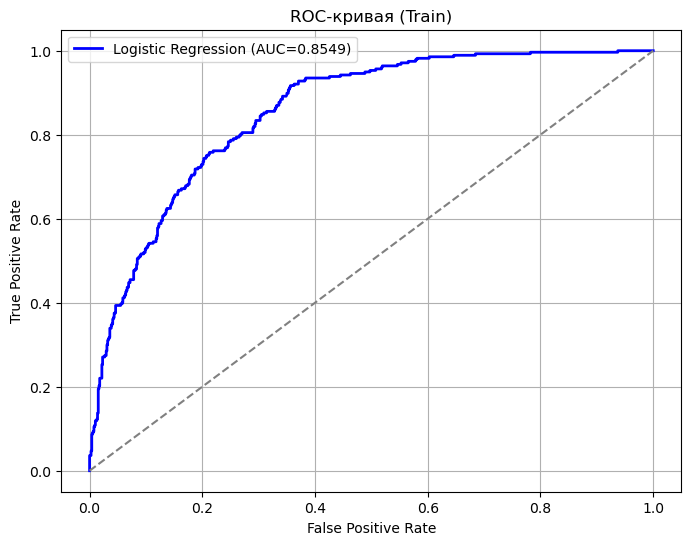

In [93]:
# Отрисуем LogisticRegression + Pipeline + GridSearchCV + 5 фолдов

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline.fit(X_train, y_train)

y_val_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_val_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr_val, tpr_val, label=f'Logistic Regression (AUC={roc_auc_val:.4f})', linewidth=2, color='blue')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая (Train)')
plt.legend()
plt.grid(True)
plt.show()


## Применение градиентного бустинга 

Теперь получим метрики с помощью градиентного бустинга

Часто градиентный бустинг с параметрами по умолчанию даст вам 80% результата за 0% усилий.

Мы будем использовать catboost -  нам не надо кодировать категориальные признаки. Catboost сделает это сам.

Сначала построим модель с параметрами по умолчанию.

In [81]:
# Градиентный бкстинг (Catboost с параметрами по умолчанию)
# Разделяем признаки и целевую, делим на train и valid
X = df_train[feature_cols].copy()
y = df_train[target_col].copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cat_model = CatBoostClassifier(random_state=42, verbose=0)
cat_model.fit(X_train, y_train, cat_features=cat_cols)

# Предсказания вероятностей
y_train_proba = cat_model.predict_proba(X_train)[:, 1]
y_valid_proba = cat_model.predict_proba(X_valid)[:, 1]

roc_auc_train = roc_auc_score(y_train, y_train_proba)
roc_auc_valid = roc_auc_score(y_valid, y_valid_proba)

print(f'ROC-AUC на train: {roc_auc_train:.4f}')
print(f'ROC-AUC на validation: {roc_auc_valid:.4f}')


ROC-AUC на train: 0.9075
ROC-AUC на validation: 0.8487


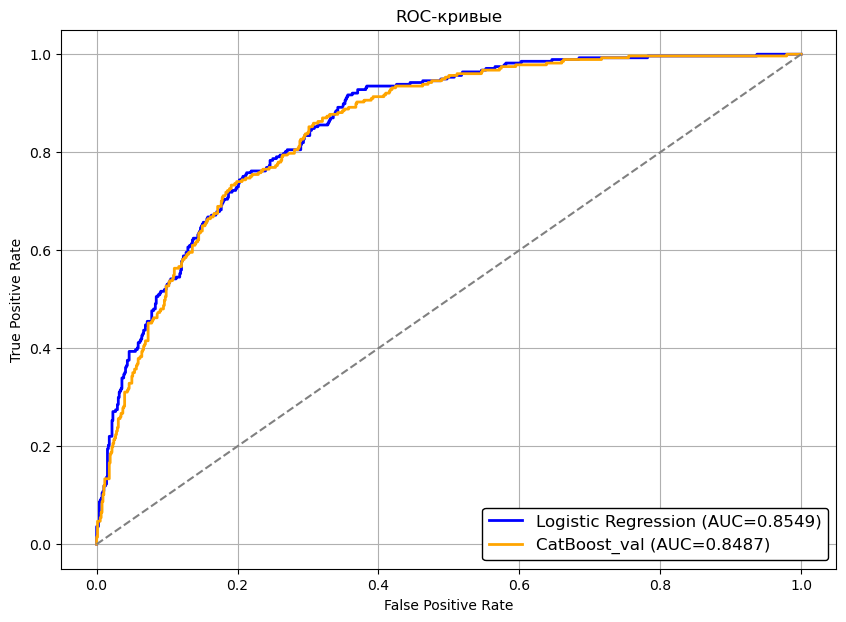

In [ ]:
fpr_cat, tpr_cat, _ = roc_curve(y_valid, y_valid_proba)

plt.figure(figsize=(10,7))
plt.plot(fpr_val, tpr_val, label=f'Logistic Regression (AUC={roc_auc_val:.4f})', linewidth=2, color='blue')
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost_val (AUC={roc_auc_valid:.4f})', linewidth=2, color='orange')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.grid(True)
plt.show()


Тперь займемся перебором параметров.

In [ ]:
# Переберем параметры
n_estimators_list = [100, 300, 500]
learning_rate_list = [0.01, 0.05, 0.1]

best_score = 0
best_params = {}

for n_est in n_estimators_list:
    for lr in learning_rate_list:
        model = CatBoostClassifier(
            iterations=n_est,
            learning_rate=lr,
            depth=6,
            random_state=42,
            verbose=0
            )
        model.fit(X_train, y_train, cat_features=cat_cols)
            
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_valid_proba = model.predict_proba(X_valid)[:, 1]
            
        roc_auc_train = roc_auc_score(y_train, y_train_proba)
        roc_auc_valid = roc_auc_score(y_valid, y_valid_proba)
            
        print(f"iterations={n_est}, learning_rate={lr}, depth=6, "
                f"ROC-AUC train={roc_auc_train:.4f}, ROC-AUC valid={roc_auc_valid:.4f}")
            
        if roc_auc_valid > best_score:
            best_score = roc_auc_valid
            best_params = {'iterations': n_est, 'learning_rate': lr}
            best_model_cat = model
                
print(f'\nЛучшие параметры: {best_params}')
print(f'Лучший ROC-AUC на validation: {best_score:.4f}')


iterations=100, learning_rate=0.01, depth=6, ROC-AUC train=0.8428, ROC-AUC valid=0.8459
iterations=100, learning_rate=0.05, depth=6, ROC-AUC train=0.8606, ROC-AUC valid=0.8550
iterations=100, learning_rate=0.1, depth=6, ROC-AUC train=0.8680, ROC-AUC valid=0.8517
iterations=300, learning_rate=0.01, depth=6, ROC-AUC train=0.8607, ROC-AUC valid=0.8530
iterations=300, learning_rate=0.05, depth=6, ROC-AUC train=0.8930, ROC-AUC valid=0.8530
iterations=300, learning_rate=0.1, depth=6, ROC-AUC train=0.9315, ROC-AUC valid=0.8421
iterations=500, learning_rate=0.01, depth=6, ROC-AUC train=0.8668, ROC-AUC valid=0.8535
iterations=500, learning_rate=0.05, depth=6, ROC-AUC train=0.9189, ROC-AUC valid=0.8476
iterations=500, learning_rate=0.1, depth=6, ROC-AUC train=0.9557, ROC-AUC valid=0.8335

Лучшие параметры: {'iterations': 100, 'learning_rate': 0.05}
Лучший ROC-AUC на validation: 0.8550


Дополнительно построим модель, убрав числовой признак 'TotalSpent', категориальные признаки подадим без изменений

In [100]:
X = X_v2.copy()
y = df_train[target_col].copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

n_estimators_list = [100, 300, 500]
learning_rate_list = [0.01, 0.05, 0.1]
depth_list = [4, 6, 8]

best_score = 0
best_params = {}

for n_est in n_estimators_list:
    for lr in learning_rate_list:
        for d in depth_list:
            model = CatBoostClassifier(
                iterations=n_est,
                learning_rate=lr,
                depth=d,
                random_state=42,
                verbose=0
            )
            model.fit(X_train, y_train, cat_features=cat_cols)
            
            y_train_proba = model.predict_proba(X_train)[:, 1]
            y_valid_proba = model.predict_proba(X_valid)[:, 1]
            
            roc_auc_train = roc_auc_score(y_train, y_train_proba)
            roc_auc_valid = roc_auc_score(y_valid, y_valid_proba)
            
            print(f"iterations={n_est}, learning_rate={lr}, depth={d}, "
                  f"ROC-AUC train={roc_auc_train:.4f}, ROC-AUC valid={roc_auc_valid:.4f}")
            
            if roc_auc_valid > best_score:
                best_score = roc_auc_valid
                best_params = {'iterations': n_est, 'learning_rate': lr, 'depth': d}
                best_model_cat = model
                
print(f'\nЛучшие параметры: {best_params}')
print(f'Лучший ROC-AUC на validation: {best_score:.4f}')

iterations=100, learning_rate=0.01, depth=4, ROC-AUC train=0.8333, ROC-AUC valid=0.8379
iterations=100, learning_rate=0.01, depth=6, ROC-AUC train=0.8398, ROC-AUC valid=0.8368
iterations=100, learning_rate=0.01, depth=8, ROC-AUC train=0.8518, ROC-AUC valid=0.8398
iterations=100, learning_rate=0.05, depth=4, ROC-AUC train=0.8529, ROC-AUC valid=0.8536
iterations=100, learning_rate=0.05, depth=6, ROC-AUC train=0.8616, ROC-AUC valid=0.8537
iterations=100, learning_rate=0.05, depth=8, ROC-AUC train=0.8698, ROC-AUC valid=0.8527
iterations=100, learning_rate=0.1, depth=4, ROC-AUC train=0.8575, ROC-AUC valid=0.8533
iterations=100, learning_rate=0.1, depth=6, ROC-AUC train=0.8667, ROC-AUC valid=0.8541
iterations=100, learning_rate=0.1, depth=8, ROC-AUC train=0.8831, ROC-AUC valid=0.8526
iterations=300, learning_rate=0.01, depth=4, ROC-AUC train=0.8519, ROC-AUC valid=0.8511
iterations=300, learning_rate=0.01, depth=6, ROC-AUC train=0.8608, ROC-AUC valid=0.8526
iterations=300, learning_rate=0.01,

Попробуем перебрать гиперпараметры с помощью Optuna. 

In [117]:
# Разделение train/validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cat_idx = [X.columns.get_loc(c) for c in cat_cols]  

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 5),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'eval_metric': 'AUC',
        'random_seed': 42,
        'verbose': False,
        'task_type': 'CPU'
    }

    model = CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=50,
        verbose=False,
        cat_features=cat_idx
    )
    y_pred_valid = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_pred_valid)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# ROC-AUC на валидации для построения кривой
best_params = study.best_params
final_model_optuna = CatBoostClassifier(**best_params)
final_model_optuna.fit(X_train, y_train, cat_features=cat_idx, eval_set=(X_valid, y_valid), verbose=False)
y_pred_valid_opt = final_model_optuna.predict_proba(X_valid)[:, 1]
roc_auc_valid_opt = roc_auc_score(y_valid, y_pred_valid_opt)
fpr_val_opt, tpr_val_opt, _ = roc_curve(y_valid, y_pred_valid_opt)

print(f"ROC-AUC на валидации: {roc_auc_valid_opt:.4f}")

print("Лучшие параметры:")
print(study.best_params)



[I 2025-10-30 09:59:21,776] A new study created in memory with name: no-name-83818cd1-77dc-47d3-bf9b-5c1dc5278654


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-30 09:59:27,876] Trial 0 finished with value: 0.8552092011478293 and parameters: {'iterations': 1485, 'depth': 10, 'learning_rate': 0.08563799507546817, 'l2_leaf_reg': 5.1230444305558, 'bagging_temperature': 4.090499905212606, 'border_count': 134, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.8552092011478293.
[I 2025-10-30 09:59:32,544] Trial 1 finished with value: 0.8540474868092197 and parameters: {'iterations': 1785, 'depth': 7, 'learning_rate': 0.08431108156561569, 'l2_leaf_reg': 7.509908810561791, 'bagging_temperature': 1.6859740363454425, 'border_count': 195, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.8552092011478293.
[I 2025-10-30 09:59:38,693] Trial 2 finished with value: 0.8528788299546424 and parameters: {'iterations': 1235, 'depth': 7, 'learning_rate': 0.02338255007976515, 'l2_leaf_reg': 1.3802879677959303, 'bagging_temperature': 1.1451787817206287, 'border_count': 194, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.8

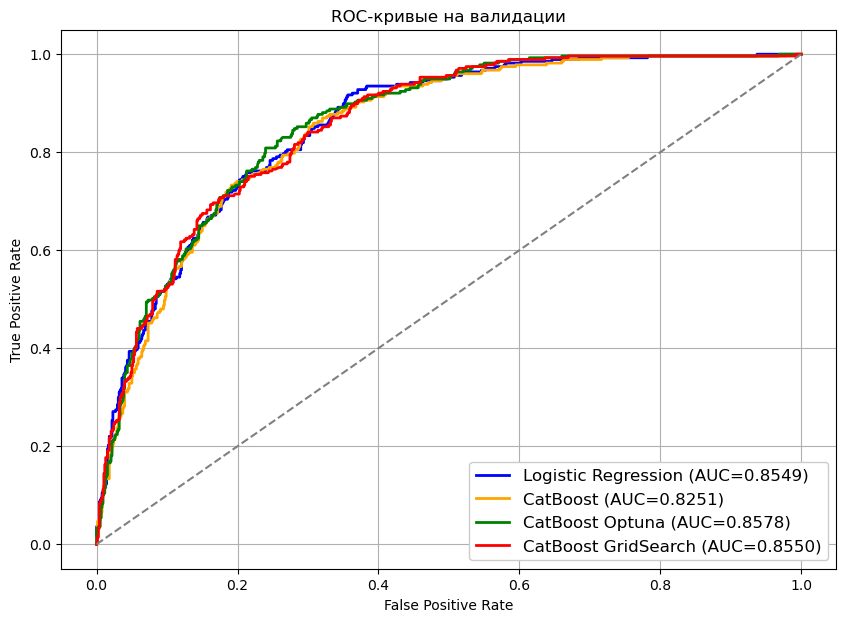

In [146]:
# Строим ROC-кривые
fpr_optuna, tpr_optuna, _ = roc_curve(y_valid, y_pred_valid_opt)

X_train_cat = X_train.copy()
X_valid_cat = X_valid.copy()
for c in cat_cols:
    X_train_cat[c] = X_train_cat[c].astype(str)
    X_valid_cat[c] = X_valid_cat[c].astype(str)

best_params_grid = {
    'iterations': 100,
    'learning_rate': 0.05,
    'random_seed': 42,
    'verbose': 0
}

best_model_grid = CatBoostClassifier(**best_params_grid)
best_model_grid.fit(X_train_cat, y_train, cat_features=cat_cols)
y_valid_pred_grid = best_model_grid.predict_proba(X_valid_cat)[:, 1]
roc_auc_valid_grid = roc_auc_score(y_valid, y_valid_pred_grid)
fpr_grid, tpr_grid, _ = roc_curve(y_valid, y_valid_pred_grid)


plt.figure(figsize=(10,7))
plt.plot(fpr_val, tpr_val, label=f'Logistic Regression (AUC={roc_auc_val:.4f})', linewidth=2, color='blue')
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC={roc_auc_valid:.4f})', linewidth=2, color='orange')
plt.plot(fpr_optuna, tpr_optuna, label=f'CatBoost Optuna (AUC={roc_auc_valid_opt:.4f})', linewidth=2, color='green')
plt.plot(fpr_grid, tpr_grid, label=f'CatBoost GridSearch (AUC={roc_auc_valid_grid:.4f})', linewidth=2, color='red')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые на валидации')
plt.legend(fontsize='large', framealpha=1)
plt.grid(True)
plt.show()


#### Итог:

Мы видим, что само маленькое значение метрики у нас получилось с Catboost с параметрами по умолчанию, но, учитывая, что на получение этой метрики было затрачено совсем мало сил, это неплохой результат для первоначальной оценки качества модели.

После перебора параметров мы достигли следующего:

**Лучшие параметры:** 

1. iterations: 100
2. learning_rate: 0.05
3. depth: 6

- `Лучший ROC-AUC на validation: 0.8550`

С использованием Optuna получили `лучший ROC-AUC на валидации: 0.8578`, что является лучшим результатом среди уже полученных. 
 
Остановимся на этой модели с выбранными Optuna параметрами.

**Лучшие параметры:**
- 'iterations': 1026, 
- 'depth': 9, 
- 'learning_rate': 0.08404215072475817, 
- 'l2_leaf_reg': 1.2179310033844848, 
- 'bagging_temperature': 1.5878565783344487, 
- 'border_count': 124, 
- 'grow_policy': 'Lossguide'

Создадим 2 модели и посмотрим их результаты

In [129]:
# Создадим модель по подобранным CatBoost параметрам 
X = df_train[feature_cols].copy()
y = df_train[target_col].copy()

# Индексы категориальных признаков
cat_idx = [X.columns.get_loc(c) for c in cat_cols]

# Параметры
best_params_simple = {
    'iterations': 100,
    'learning_rate': 0.05,
    'random_seed': 42,
    'eval_metric': 'AUC',
    'verbose': False,
    'task_type': 'CPU'
}

# Pipeline 
pipeline_catb = Pipeline([
    ('select_features', FunctionTransformer(lambda df: df[feature_cols], validate=False)),
    ('catboost', CatBoostClassifier(**best_params_simple))
])

# Обучение финальной модели
pipeline_catb.fit(X, y, catboost__cat_features=cat_idx)

# Предсказание на тестовой выборке
# y_pred_test = pipeline_catb.predict_proba(df_test)[:, 1]

Pipeline(steps=[('select_features',
                 FunctionTransformer(func=<function <lambda> at 0x0000011981057CE0>)),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x00000119F6E3E9C0>)])

In [128]:
# Создадим модель по подобранным optuna параметрам 

X = df_train[feature_cols].copy()
y = df_train[target_col].copy()

cat_idx = [X.columns.get_loc(c) for c in cat_cols]

best_params = {
    'iterations': 1329,
    'depth': 7,
    'learning_rate': 0.055568596339936625,
    'l2_leaf_reg': 1.3195142540711462,
    'bagging_temperature': 4.303132058956126,
    'border_count': 43,
    'grow_policy': 'Lossguide',
    'random_seed': 42,
    'verbose': False,
    'task_type': 'CPU'
}

# Pipeline
pipeline_optuna = Pipeline([
    ('select_features', FunctionTransformer(lambda df: df[feature_cols], validate=False)),
    ('catboost', CatBoostClassifier(**best_params))
])

# Обучение финальной модели
pipeline_optuna.fit(X, y, catboost__cat_features=cat_idx)

# Предсказание на тестовой выборке
# y_pred_test = pipeline_optuna.predict_proba(df_test)[:, 1]

Pipeline(steps=[('select_features',
                 FunctionTransformer(func=<function <lambda> at 0x0000011981056480>)),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x00000119EA44E210>)])

In [130]:
# Предсказание вероятностей на train
y_pred_train_simple = pipeline_catb.predict_proba(X)[:, 1]

# ROC-AUC на train
roc_auc_train_simple = roc_auc_score(y, y_pred_train_simple)
print(f"ROC-AUC на train (простая модель): {roc_auc_train_simple:.4f}")

# Предсказание вероятностей на train
y_pred_train = pipeline_optuna.predict_proba(X)[:, 1]

# ROC-AUC на train
roc_auc_train = roc_auc_score(y, y_pred_train)
print(f"ROC-AUC на train (optuna): {roc_auc_train:.4f}")


ROC-AUC на train (простая модель): 0.8602
ROC-AUC на train (optuna): 0.9979


Слишком высокий показатель на обучающей выборке при примерно равных метриках на валидационной может говорит о переобучении.

Проверим на тесте.

# Предсказания

Применим нашу модель на практике

In [148]:
best_model_cat = pipeline_catb
best_model_optuna = pipeline_optuna

submission = pd.read_csv('submission.csv')


In [ ]:
#X_test = pd.read_csv('./test.csv')

In [149]:
submission['Churn'] = best_model_cat.predict_proba(df_test)[:, 1]
submission.to_csv('my_submission_cat.csv', index=False)

In [150]:
submission['Churn'] = best_model_optuna.predict_proba(df_test)[:, 1]
submission.to_csv('my_submission_optuna.csv', index=False)

In [151]:
print('Мерика ROC-AUC на модели pipeline_catb равна 0,85135')
print('Мерика ROC-AUC на модели pipeline_optuna равна 0,81900')

Мерика ROC-AUC на модели pipeline_catb равна 0,85135
Мерика ROC-AUC на модели pipeline_optuna равна 0,81900


Для наших целей лучше всего себя показала модель `pipeline_catb`

## Итоги:

1. Для категориальных признаков было применено One-hot кодирование, что позволило преобразовать их в числовой формат, необходимый для обучения моделей машинного обучения. 

2. К категориальным признаков было применено One-hot кодирование, а числовые подверглись масштабированю, что необходимо для корректной работы моделей машинного обучения.

3. Чтобы избежать переобучения, мы применили регуляризацию и кросс-валидацию.

4. Рассмотрены несколько моделей: логистическа регрессия с кросс-валидацией и без, бустингов(CatBoost), что было очень актуально - в датасете большое количество категориальных признаков.

5. Наилучшие результаты были достигнуты с использованием бустинговых моделей, которые смогли достичь более высокого качества предсказания.

6. Важно помнить о необходимости использования воспроизводимых методов предобработки данных, таких как обучаемые энкодеры, чтобы исключить утечки информации между обучающей и тестовой выборками.